<p style="text-align: center;">
  <em>Made with <span style="color: red;">❤️</span> and <a href="https://github.com/features/copilot" target="_blank">GitHub Copilot</a></em>
  <br>
  <img src="https://github.githubassets.com/images/icons/emoji/octocat.png" alt="GitHub Copilot Logo" width="50">
</p>

# Sklearn vs R model APIs

<p style="text-align: center;">
  <img src="r_logo.png" alt="R Logo" width="150" style="display: inline-block; margin-right: 50px;">
  <span style="font-size: 24px; font-weight: bold;">VS</span>
  <img src="scikit_learn_logo.png" alt="Scikit-learn Logo" width="150" style="display: inline-block; margin-left: 50px;">
</p>


## Introduction

Many computing on data rely on R and scikit-learn as primary tools for statistical modeling and machine learning. While both languages offer powerful capabilities for creating and working with models, they employ distinct approaches to model creation and fitting. This blog post explores these differences, focusing on how models are instantiated and fitted in each language. The comparison will examine linear models with toy synthetic data.

Note that the discussion is of R with the dominance of S3 classes (and so generic functions) for popular established models, and scikit-learn for Python. The scikit-learn model approach has become the standard in many Python frameworks, including Keras, mlx and PyTorch. (Some discussions on the topic of R vs Python for computing on data focus on the languages themselves, but this post will focus on the model APIs, in particular how instantiation, fit and predict are invoked.)

## R's Approach: Implicit Fitting and S3 Classes

In R, model fitting is often implicit and occurs at the time of model creation. This is facilitated by R's use of S3 classes, which are based on generic functions.

(There are many OOP paradigms used for model fitting in R - more on this later. By far the most popular for an important class of models is using the S3 system.)

### Understanding S3 Generic Functions

S3 is R's first and most widely used object-oriented system. It's based on generic functions, which provide a simple yet powerful way to implement polymorphism in R. Here's how S3 generic functions work:

1. A generic function is a function that dispatches method calls to other functions, based on the class of the arguments passed to it.

2. When a generic function is called, R looks for a method that matches the class of the object passed as an argument.

3. If a matching method is found, it is called; otherwise, R looks for a default method.

Let's look at an example using the `print()` function, which is a common S3 generic:

In [1]:
# Define a new S3 class
create_human <- function(name, age) {
  human <- list(name = name, age = age)
  class(human) <- "human"
  return(human)
}

# Define a method for the print generic
print.human <- function(x, ...) {
  cat("Human Attributes \n")
  cat("Name: ", x$name, "\n")
  cat("Age: ", x$age, "\n")
}

# Create an object and print it
john <- create_human("John Doe", 30)
print(john)

Human Attributes 
Name:  John Doe 
Age:  30 


In this example:
- We define a new S3 class called "human".
- We create a method `print.human()` for the `print()` generic function.
- When we call `print(john)`, R recognizes that `john` is of class "human" and calls our `print.human()` method.

This system allows for intuitive and flexible implementation of methods for different classes. In the context of modeling, it enables R to provide a consistent interface for various model types while allowing for specialized behavior based on the specific model class.

### S3 Classes for Models

R uses S3 classes for many of its modeling functions. Some examples include:

- `lm` for linear models
- `glm` for generalized linear models
- `rpart` for decision trees
- `randomForest` for random forest models

When you create a model object using these functions, you are actually creating an instance of an S3 class.

These classes come with predefined generic function methods for common operations like `print()`, `summary()`, and `predict()`, which behave differently depending on the model type.

### Implicit Fitting

In R, when a model-type object is instantiated with a call, it is typically fitted automatically. Let's look at linear model as a simple example.

But first we need some data, we'll use a toy example - to illustrate the model fitting process. 

By using toy synthetic data, we are avoiding details such as:

- Data cleaning
- Input imbalance
- Output imbalance
- Multi-collinearity
- Multiple features
- Perfect separation
- Imputation
- Encoding
- Feature scaling
- Handling outliers (either removing them, or replacing them with a reasonable value, or even considering robust models)

We will need a split function to split the data into train-dev-test sets.

In [2]:
split_data <- function(data, train_ratio = 0.7, dev_ratio = 0.15, test_ratio = 0.15, seed = 123) {
  # Check that the ratios sum to 1
  if (train_ratio + dev_ratio + test_ratio != 1) {
    stop("The sum of train_ratio, dev_ratio, and test_ratio must be 1.")
  }
  
  # Set seed for reproducibility
  set.seed(seed)
  
  # Calculate the number of samples for each set
  n <- nrow(data)
  train_size <- floor(train_ratio * n)
  dev_size <- floor(dev_ratio * n)
  
  # Generate random indices for the training set
  train_indices <- sample(seq_len(n), size = train_size)
  
  # Generate random indices for the dev set from the remaining indices
  remaining_indices <- setdiff(seq_len(n), train_indices)
  dev_indices <- sample(remaining_indices, size = dev_size)
  
  # The remaining indices are for the test set
  test_indices <- setdiff(remaining_indices, dev_indices)
  
  # Split the data
  train_data <- data[train_indices, ]
  dev_data <- data[dev_indices, ]
  test_data <- data[test_indices, ]
  
  return(list(train = train_data, dev = dev_data, test = test_data))
}

Great. Now we can generate synthetic data suitable for a linear model, and split it into train-dev-test sets.


In [3]:
generate_linear_data <- function(n = 100, seed = 123, slope = 2, intercept = 5, noise_sd = 1) {
  # Set seed for reproducibility
  set.seed(seed)
  
  # Generate predictor variable (x)
  x <- runif(n, min = 0, max = 10)
  
  # Generate response variable (y) with a linear relationship and some noise
  y <- intercept + slope * x + rnorm(n, mean = 0, sd = noise_sd)
  
  # Create a dataframe
  data <- data.frame(x = x, y = y)
  
  return(data)
}

# Generate the data
linear_data <- generate_linear_data(n = 100, seed = 123, slope = 2, intercept = 5, noise_sd = 1)

# Display the first few rows of the data
df <- split_data(linear_data)
head(df$train)

,x,y
,<dbl>,<dbl>
31,9.6302423,24.266249
79,3.5179791,11.074102
51,0.4583117,5.206217
14,5.7263340,15.434093
67,8.1006435,21.306963
42,4.1454634,13.839324


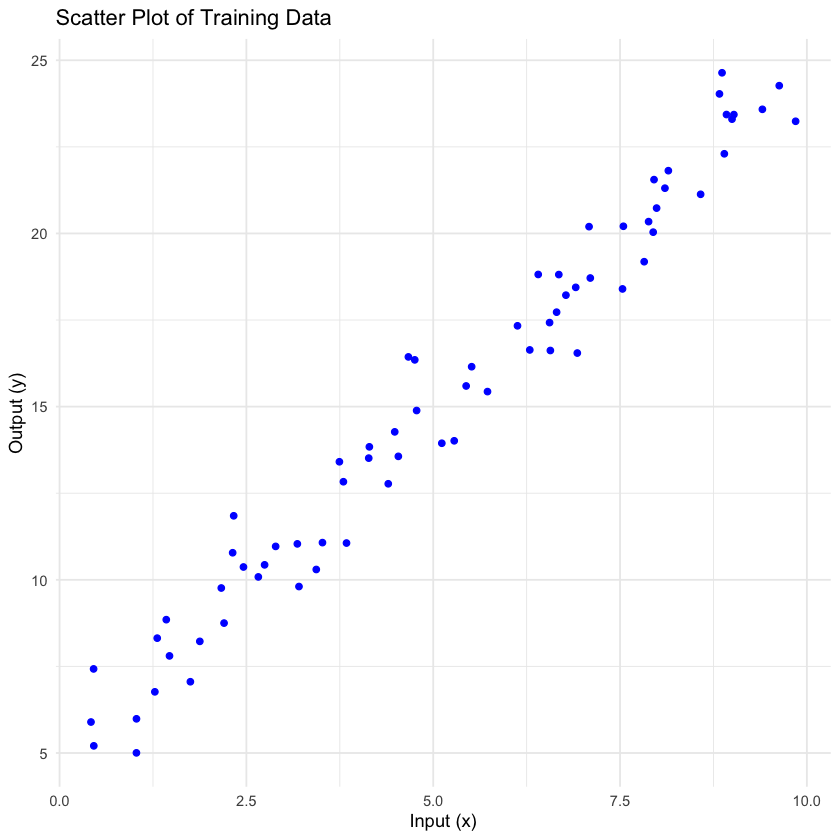

In [6]:
library(ggplot2)

ggplot(df$train, aes(x = x, y = y)) +
  geom_point(color = "blue") +
  labs(title = "Scatter Plot of Training Data",
       x = "Input (x)",
       y = "Output (y)") +
  theme_minimal()

Now let's work with the training data. We'll fit a linear model to predict `y` based on `x` using the dev set. For completeless we have split out a test set to evaluate the model's final performance if we had tuned on the dev set or compared against other models.

Linear Regression

In [7]:
# Fit a simple linear regression model
lm_model <- lm(y ~ x, data = df$train)

# Summarize the model
summary(lm_model)



Call:
lm(formula = y ~ x, data = df$train)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.13378 -0.74871 -0.05242  0.59871  2.34082 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.85761    0.26186   18.55   <2e-16 ***
x            1.99524    0.04485   44.49   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.018 on 68 degrees of freedom
Multiple R-squared:  0.9668,	Adjusted R-squared:  0.9663 
F-statistic:  1979 on 1 and 68 DF,  p-value: < 2.2e-16


We can visually inspect the model's fit by plotting the data points and the regression line.

`geom_smooth()` using formula = 'y ~ x'


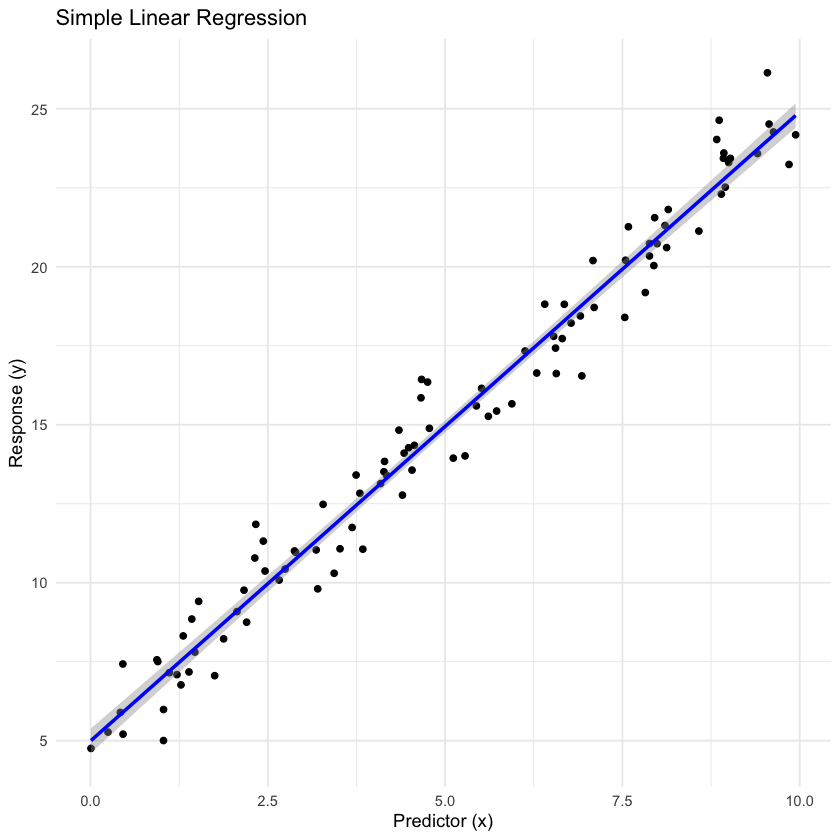

In [8]:
ggplot(linear_data, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm", col = "blue") +
  labs(title = "Simple Linear Regression",
       x = "Predictor (x)",
       y = "Response (y)") +
  theme_minimal()

An objective evaluation metric, or score provides an comparable measure of model performance. In this case, we'll use the mean absolute percentage error (MAPE) on the dev set.

In [9]:
# Generate predictions for the development set
dev_predictions <- predict(lm_model, newdata = df$dev)

# Calculate Mean Absolute Percentage Error (MAPE)
calculate_mape <- function(actual, predicted) {
  mean(abs((actual - predicted) / actual)) * 100
}

# Calculate MAPE for the development set
mape <- calculate_mape(df$dev$y, dev_predictions)
print(paste("Mean Absolute Percentage Error (MAPE) on Dev Set: ", round(mape,2), "%", sep = ""))

[1] "Mean Absolute Percentage Error (MAPE) on Dev Set: 4.49%"


Cool, we've successfully fitted a linear regression model in R! Note that we used the instance based fitting  and predicted using the s3 class method.

Let's spell this out in a more detailed way:

- We created a linear model object using the `lm()` function. When this object was created, the model was fitted to the training data at the same time.
- We used the `predict()` method of the model object to make predictions on the dev set.

The underlying s3 class system in R allows for this implicit fitting and prediction process, making it easy to work with models in a consistent manner.

A sketch of the flow is:

![S3 workflow of fit and predict](./s3_fit_predict_flow.png)

And a very rough sketch of the code, without all the details (calls to C and FORTRAN routines, checks for edge cases, convergence criteria, etc.):

```R
lm <- function(formula, data, ...) {
  # Step 1: Extract the model frame from formula and data
  mf <- model.frame(formula = formula, data = data)
  
  # Step 2: Create model matrix (X) and response vector (y)
  X <- model.matrix(attr(mf, "terms"), mf)
  y <- model.response(mf)
  
  # Step 3: QR decomposition to solve for coefficients
  fit <- qr.solve(qr(X), y)
  
  # Step 4: Create lm object with fitted values and residuals
  result <- list(coefficients = fit$coefficients,
                 residuals = y - X %*% fit$coefficients,
                 fitted.values = X %*% fit$coefficients,
                 qr = qr(X),
                 terms = terms(formula),
                 call = match.call())
  
  class(result) <- "lm"  # Assign class "lm"
  return(result)
}

fit <- function(formula, data, model_type = "lm", ...) {
  UseMethod("fit", model_type)  # Dispatch based on model_type
}

fit.lm <- function(formula, data, ...) {
  # Calls lm() to fit the linear model
  model <- lm(formula, data = data, ...)
  return(model)
}

predict <- function(object, ...) {
  UseMethod("predict")
}

predict.lm <- function(object, newdata, ...) {
  # Step 1: Construct model matrix for new data
  new_X <- model.matrix(terms(object), newdata)
  
  # Step 2: Use the coefficients to calculate predictions
  preds <- new_X %*% coef(object)
  
  return(preds)
}
```

A brief outline of the code snippet:

- The `lm()` function creates a linear model object by solving the normal equations using QR decomposition. It depends on receiving a formula and data as input at the time of instantiation.
- The `fit()` function is a generic function that dispatches to specific fitting functions based on the model type.
- The `fit.lm()` function fits a linear model using the `lm()` function.

All of this depends on S3 classes and generic functions.

Now moving on, let's use the same dataset with Python using scikit-learn. We'll save it down to a csv file and load it into a pandas dataframe.

In [10]:
write.csv(df$train, "train_data.csv", row.names = FALSE)
write.csv(df$dev, "dev_data.csv", row.names = FALSE)

## Python's Approach: Explicit Fitting with Scikit-learn

Python, on the other hand, takes a more explicit approach to model fitting, especially when using the popular machine learning library Scikit-learn.


Let's load the data for train and dev sets.



In [1]:
import pandas as pd
df_train = pd.read_csv("train_data.csv")
df_dev = pd.read_csv("dev_data.csv")

### Class-Based Implementation

Python uses a more traditional class-based implementation for its models. In scikit-learn, models are implemented as classes with specific methods for fitting and prediction.

### The scikit-learn Interface

The scikit-learn library in Python uses a consistent interface across its models, with separate `fit()` and `predict()` methods. Here's how this looks for Linear Regression

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error


model = LinearRegression() # instantiation
model.fit(df_train[['x']], df_train['y'])  # fitting the model

# Generate predictions for the development set
dev_predictions = model.predict(df_dev[['x']])  # prediction

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df_dev['y'], dev_predictions) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Dev Set: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) on Dev Set: 4.49%



This approach separates the model instantiation, fitting, and prediction steps, providing more explicit control over the process.

## Comparing the Two Approaches

Both approaches have their merits:

1. R's approach is more concise and can be more intuitive for statistical modeling. It's particularly convenient for quick exploratory data analysis.

2. Python's approach provides more explicit control and is consistent across different types of models. This can be beneficial in production environments where you might want more fine-grained control over the fitting process.

### Advantages of R's Approach:
- More concise code for simple modeling tasks
- Intuitive for statisticians used to thinking in terms of model formulas
- Easy to quickly try out different model specifications

### Advantages of Python's Approach:
- Consistent interface across different types of models
- More explicit control over the fitting process
- Easier to integrate into larger software systems due to its object-oriented nature

## Swapping Styles

### Simulating R-style Instantiation in Python

While Python's default approach is different, it's possible to simulate R-style instantiation and fitting more closely. Here's an implementation that mirrors R's behavior, allowing for a two-step process of defining the model class and then fitting it with data:

In [7]:
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class RStyleModel:
    def __init__(self, model_class, **kwargs):
        self.model_class = model_class
        self.kwargs = kwargs
        self.fitted_model = None

    def __call__(self, formula, data):
        # Parse the formula
        y, X = self._parse_formula(formula, data)
        
        # Create and fit the model
        self.fitted_model = self.model_class(**self.kwargs)
        self.fitted_model.fit(X, y)
        
        return self

    def predict(self, X):
        if self.fitted_model is None:
            raise ValueError("Model has not been fitted yet.")
        return self.fitted_model.predict(X)

    def _parse_formula(self, formula, data):
        # Simple formula parsing (for demonstration purposes)
        response, predictors = formula.split('~')
        y = data[response.strip()]
        if predictors.strip() == '.':
            X = data.drop(response.strip(), axis=1)
        else:
            X = data[[p.strip() for p in predictors.split('+')]]
        return y, X

# Usage
lm = RStyleModel(LinearRegression)
# Assuming 'my_data' is a pandas DataFrame
lm('y ~ x', df_train)

# Predictions
linear_predictions = lm.predict(df_dev[['x']])

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(df_dev['y'], linear_predictions) * 100
print(f"Mean Absolute Percentage Error (MAPE) on Dev Set: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) on Dev Set: 4.49%


Wonderful the results match the R implementation. This approach provides a more R-like workflow in Python, making it easier for R users to transition to Python for modeling tasks.

This implementation provides several R-like features:

1. Model Class Definition: We define the model classes using names familiar to R users: `lm` for linear models, `randomForest` for random forests, and `glm` for generalized linear models (in this case, logistic regression).

2. Formula Interface: We use an R-like formula syntax for model fitting (e.g., `y ~ x` or `y ~ .` for all variables).

3. Implicit Fitting: The model is fitted when we call the model class with a formula and data, similar to R's behavior.

4. Familiar Prediction: We use the `predict` method on the fitted model object, just like in R.

5. Flexibility: This approach works for different types of models with a consistent interface, mirroring R's functionality.

This implementation closely mirrors R's workflow while still leveraging Python's scikit-learn backend. It provides a familiar interface for R users while maintaining the flexibility and power of Python's machine learning ecosystem.

### Simulating Python-style Instantiation in R

Conversely, it's also possible to simulate Python's explicit fitting approach in R. While this is less common due to R's default behavior, it can be achieved by creating custom classes and methods that separate model instantiation from fitting. 

There are many object oriented systems in R - you can find a discussion in Hadley Wickham's [Advanced R](https://adv-r.hadley.nz/oo.html#oo) book.

There are many, many ways to do this in R, and the examples below are just a few possibilities. 

S3:

```r
# Define the LinearRegression S3 class
LinearRegression <- function() {
  structure(list(coefficients = NULL, intercept = NULL), class = "LinearRegression")
}

# Fit method
fit.LinearRegression <- function(model, X, y) {
  X <- cbind(1, X)  # Add intercept term
  beta <- solve(t(X) %*% X) %*% t(X) %*% y  # Normal equation
  model$intercept <- beta[1]
  model$coefficients <- beta[-1]
  return(model)
}

# Predict method
predict.LinearRegression <- function(model, X) {
  X <- cbind(1, X)  # Add intercept term
  return(X %*% c(model$intercept, model$coefficients))  # Predictions
}

# Score method (R-squared)
score.LinearRegression <- function(model, X, y) {
  preds <- predict(model, X)
  ss_res <- sum((y - preds) ^ 2)
  ss_tot <- sum((y - mean(y)) ^ 2)
  return(1 - (ss_res / ss_tot))  # R-squared
}

model <- LinearRegression()
model <- fit(model, df$train["x"], df$train["y"])
print(score(model, df$train["x"], df$train["y"]))
```

or another implementation using S4:

```r
# Define the LinearRegression S4 class
setClass(
  "LinearRegression",
  slots = list(
    coefficients = "numeric",
    intercept = "numeric"
  )
)

# Define the fit method
setGeneric("fit", function(model, X, y) standardGeneric("fit"))
setMethod("fit", "LinearRegression", function(model, X, y) {
  X <- cbind(1, X)  # Add intercept term
  beta <- solve(t(X) %*% X) %*% t(X) %*% y  # Normal equation
  model@intercept <- beta[1]
  model@coefficients <- beta[-1]
  return(model)
})

# Define the predict method
setGeneric("predict", function(model, X) standardGeneric("predict"))
setMethod("predict", "LinearRegression", function(model, X) {
  X <- cbind(1, X)  # Add intercept term
  return(X %*% c(model@intercept, model@coefficients))  # Predictions
})

# Define the score method (R-squared)
setGeneric("score", function(model, X, y) standardGeneric("score"))
setMethod("score", "LinearRegression", function(model, X, y) {
  preds <- predict(model, X)
  ss_res <- sum((y - preds) ^ 2)
  ss_tot <- sum((y - mean(y)) ^ 2)
  return(1 - (ss_res / ss_tot))  # R-squared
})

model <- new("LinearRegression")
model <- fit(model, df$train["x"], df$train["y"])
print(score(model, df$train["x"], df$train["y"]))
```

or using Reference Classes:

```r
# Define the LinearRegression reference class
LinearRegression <- setRefClass(
  "LinearRegression",
  
  fields = list(
    coefficients = "numeric",
    intercept = "numeric"
  ),
  
  methods = list(
    fit = function(X, y) {
      X <- cbind(1, X)  # Add intercept term
      beta <- solve(t(X) %*% X) %*% t(X) %*% y  # Normal equation
      intercept <<- beta[1]
      coefficients <<- beta[-1]
      invisible(self)
    },
    
    predict = function(X) {
      X <- cbind(1, X)  # Add intercept term
      return(X %*% c(intercept, coefficients))  # Predictions
    },
    
    score = function(X, y) {
      preds <- predict(X)
      ss_res <- sum((y - preds) ^ 2)
      ss_tot <- sum((y - mean(y)) ^ 2)
      return(1 - (ss_res / ss_tot))  # R-squared
    }
  )
)

model <- LinearRegression$new()
model$fit(df$train["x"], df$train["y"])
print(model$score(df$train["x"], df$train["y"]))
```

or R6:

```r
library(R6)

LinearRegression <- R6Class(
  "LinearRegression",
  
  public = list(
    coefficients = NULL,
    intercept = NULL,
    
    fit = function(X, y) {
      X <- cbind(1, X)  # Add intercept term
      beta <- solve(t(X) %*% X) %*% t(X) %*% y  # Normal equation
      self$intercept <- beta[1]
      self$coefficients <- beta[-1]
      invisible(self)
    },
    
    predict = function(X) {
      X <- cbind(1, X)  # Add intercept term
      return(X %*% c(self$intercept, self$coefficients))  # Predictions
    },
    
    score = function(X, y) {
      preds <- self$predict(X)
      ss_res <- sum((y - preds) ^ 2)
      ss_tot <- sum((y - mean(y)) ^ 2)
      return(1 - (ss_res / ss_tot))  # R-squared
    }
  )
)

# Example usage
df_binary <- data.frame(Sal = c(1, 2, 3, 4, 5), Temp = c(15, 20, 25, 30, 35))
X <- as.matrix(df_binary$Sal)
y <- as.matrix(df_binary$Temp)

model <- LinearRegression$new()
model$fit(df$train["x"], df$train["y"])
print(model$score(df$train["x"], df$train["y"]))
```

## Conclusion

R and Python, while both powerful tools for data analysis and modeling, have different default approaches to model creation and fitting. 
Although R has many OOP paradigms, for many popular models R leverages S3 classes and generic functions, and is often more concise and intuitive for statistical modeling. It allows for quick model specification and is particularly suited for exploratory data analysis.

Python's approach, exemplified by the scikit-learn library, offers more explicit control and consistency across different types of models. This can be advantageous in production environments and when integrating models into larger software systems.

Understanding these differences can help those computing on data choose the right tool for their specific needs and workflow preferences. Whether one prefers R's implicit fitting or Python's explicit approach, both languages offer flexible and powerful options for a wide range of statistical modeling and machine learning tasks, from simple linear regression to complex ensemble methods like random forests.

The choice between R and Python often comes down to the specific requirements of the project, the background of the practitioner, and the broader ecosystem in which the analysis or model will be deployed. By understanding the strengths of each approach, data professionals can make informed decisions and leverage the best of both worlds when necessary.

Moreover, as demonstrated in the last section, it's possible to create interfaces in Python that mimic R's behavior, providing a bridge for those transitioning between the two languages or working in mixed environments. This flexibility highlights the power of both languages and the creativity of the data science community in adapting tools to suit their needs.